In [12]:
import numpy as np

# Set the seed for reproducibility (optional)
np.random.seed(42)

# Length of the vectors
n = 100

# Generate the predictor X
x = np.random.randn(100, 1)

# Generate the noise vector eps
eps = np.random.randn(100, 1)

In [13]:
betas = [5, -10, 3, 14]

y = betas[0] + betas[1] * x + betas[2] * (x**2) + betas[3] * (x**3) + eps

In [15]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(x)

cols = ['x'+str(i) for i in range(1, 11)] + ['y']
X_df = pd.DataFrame(np.concatenate((X_poly,y), axis=1), columns=cols)
X_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.496714,0.246725,0.122552,0.060873,0.030237,0.015019,7.460119e-03,3.705547e-03,1.840597e-03,9.142508e-04,1.073387
1,-0.138264,0.019117,-0.002643,0.000365,-0.000051,0.000007,-9.659851e-07,1.335613e-07,-1.846675e-08,2.553293e-09,5.982344
2,0.647689,0.419500,0.271706,0.175981,0.113981,0.073824,4.781493e-02,3.096918e-02,2.005838e-02,1.299158e-02,3.242780
3,1.523030,2.319620,3.532850,5.380637,8.194870,12.481032,1.900898e+01,2.895125e+01,4.409362e+01,6.715590e+01,45.386190
4,-0.234153,0.054828,-0.012838,0.003006,-0.000704,0.000165,-3.859250e-05,9.036565e-06,-2.115942e-06,4.954550e-07,7.164998


In [24]:
import statsmodels.api as sm
from itertools import combinations
from tqdm import tqdm

def process_linear_model(subset, data, response):
    x_train = sm.add_constant(data[subset])
    model = sm.OLS(response, x_train).fit()
    train_RSS = model.ssr
    return (model, train_RSS)

def find_best_subset(data, response, max_features, operation):
    best_sub_list = []
    best_model = []
    num_of_features = []
    
    for k in tqdm(range(1, max_features+1)):
        best_rss = np.inf
        best_kth_model = None
        
        subsets = combinations(data.columns, k)
        
        for subset in subsets:
            result = process_linear_model(list(subset), data, response)
            if result[1] < best_rss:
                best_rss = result[1]
                best_subset = list(subset)
                best_kth_model = result[0]
                
        num_of_features.append(k)
        best_sub_list.append(best_subset)
        best_model.append(best_kth_model)
            
    results = pd.DataFrame({'sub': best_sub_list, 'model': best_model})
    results.to_pickle(f'{operation}.pkl')
    return results

In [25]:
X = X_df.drop(['y'], axis=1)
y = X_df.y

bestsub_results = find_best_subset(X, y, 10, 'poly_bestsub')

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


In [26]:
# best subset selection results
bestsub_results

,sub,model
0,[x3],<statsmodels.regression.linear_model.Regressio...
1,"[x1, x3]",<statsmodels.regression.linear_model.Regressio...
2,"[x1, x2, x3]",<statsmodels.regression.linear_model.Regressio...
3,"[x1, x2, x3, x10]",<statsmodels.regression.linear_model.Regressio...
4,"[x1, x2, x3, x7, x9]",<statsmodels.regression.linear_model.Regressio...
5,"[x1, x2, x3, x6, x8, x10]",<statsmodels.regression.linear_model.Regressio...
6,"[x1, x2, x3, x4, x6, x8, x10]",<statsmodels.regression.linear_model.Regressio...
7,"[x1, x2, x3, x4, x5, x6, x8, x10]",<statsmodels.regression.linear_model.Regressio...
8,"[x1, x2, x3, x4, x5, x6, x7, x8, x10]",<statsmodels.regression.linear_model.Regressio...
9,"[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...


In [27]:
aic = [bestsub_results.model[i].aic for i in range(0, len(bestsub_results.model))]
bic = [bestsub_results.model[i].bic for i in range(0, len(bestsub_results.model))]
r2_adj = [bestsub_results.model[i].rsquared_adj for i in range(0, len(bestsub_results.model))]
rss = [bestsub_results.model[i].ssr for i in range(0, len(bestsub_results.model))]

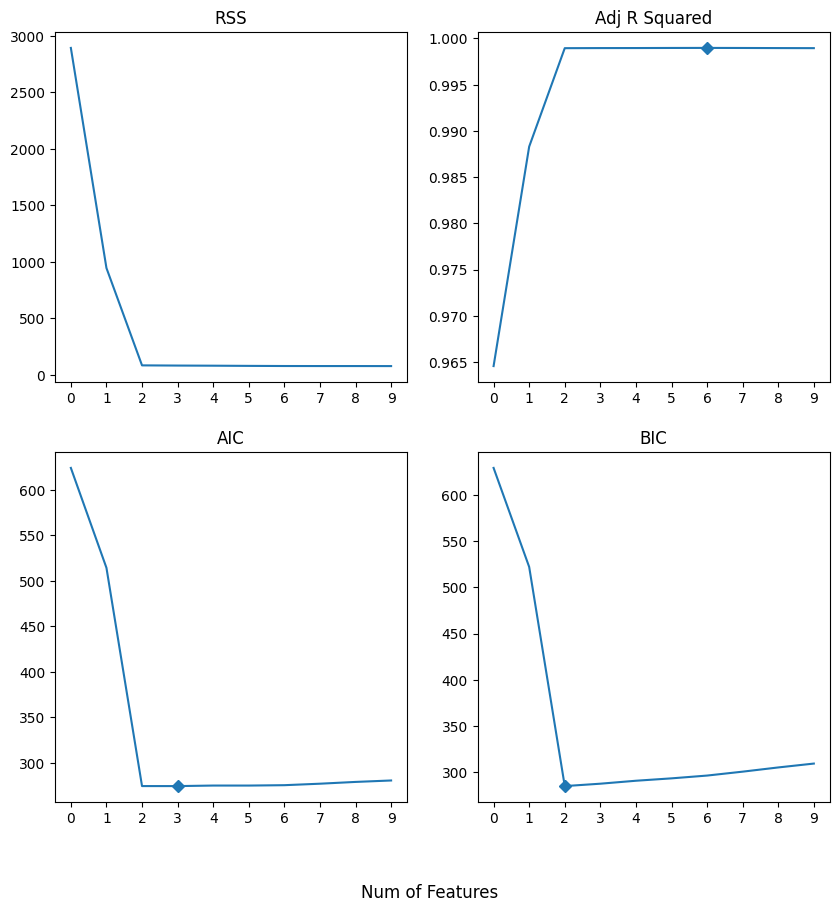

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

axes[0, 0].plot(rss)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj, markevery=[np.argmax(r2_adj)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic, markevery=[np.argmin(aic)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic, markevery=[np.argmin(bic)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

The best model obtained:

According to:

- BIC => 2-variable model [x1, x3]
- Adjusted R2 => 6-variable model [x1, x2, x3, x6, x8, x10]
- AIC => 3-variable model [x1, x2, x3]

In [31]:
# Coefficient estimates for best model obtained acc.to BIC
bestsub_results.model[1].params

const     7.211349
x1       -8.324242
x3       12.786700
dtype: float64

In [32]:
# Coefficient estimates for best model obtained acc.to Adjusted R2
bestsub_results.model[5].params

const     4.729329
x1      -10.047974
x2        3.780139
x3       13.999950
x6       -0.381452
x8        0.143770
x10      -0.013174
dtype: float64

In [33]:
# Coefficient estimates for best model obtained acc.to AIC
bestsub_results.model[2].params

const     4.847927
x1      -10.135707
x2        3.206938
x3       14.028366
dtype: float64